In [50]:
# Import packages
import sys
!{sys.executable} -m pip install world_bank_data
!{sys.executable} -m pip install xlrd
import pandas as pd
import world_bank_data as wb
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import calendar
import seaborn as sns
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### 1. Get Data from John Hopkins 

In [25]:
# Loading Covid 19 Data
public_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
corona_data = pd.read_csv(public_url)
corona_data.drop(['Lat','Long','Province/State'],axis=1)
countries = sorted(corona_data['Country/Region'].unique())
country_data = corona_data.groupby('Country/Region').sum()
country_data = country_data.drop(['Lat','Long'],axis=1)
country_data = country_data.rename(columns={'Country/Region':'Country'},index={'US':'United States'})

### 2. Get Data from the World Bank

In [94]:
# Get GDP data
GDP = pd.DataFrame(wb.get_series('NY.GDP.MKTP.CD',mrv=1))
GDP = GDP.droplevel(level=[1,2]) # Droping multi level indexing

# Get gini Index
Gini = pd.DataFrame(wb.get_series('SI.POV.GINI',date = '2010'))
Gini = Gini.droplevel(level=[1,2]) # Droping multi level indexing

# Get population data
Pop = pd.DataFrame(wb.get_series('SP.POP.TOTL',mrv=1))
Pop = Pop.droplevel(level=[1,2]) # Droping multi level indexing

# Get Health System Data
Health = pd.DataFrame(wb.get_series('SH.MED.BEDS.ZS',date = '2010'))
Health = Health.droplevel(level=[1,2]) # Droping multi level indexing

# Get Density Data
Dens = pd.DataFrame(wb.get_series('EN.POP.DNST',mrv=1))
Dens = Dens.droplevel(level=[1,2])

# Get Trade data
Trade = pd.DataFrame(wb.get_series('NE.TRD.GNFS.ZS',mrv=1))
Trade = Trade.droplevel(level=[1,2])

#Get total number of cases 
Total = pd.DataFrame(country_data.sum(axis=1), columns=['Total'])


### Religion Data

In [27]:
religion = pd.read_excel('religious-diversity-index.xlsx')
religion = religion.set_index('Country')
religion = religion.drop('2010 Country Population',axis = 1)
religion = religion.replace('< 0.1%',0) # Smaller than 0.1 % is transformed to zero
temp = religion.drop('RDI',axis=1).idxmax(axis=1)
MainReligion = temp.replace(temp.unique(),
                ['Muslim','Christian','Buddhist','Unaffiliated'
                 ,'Hindu','Jewish','Folk'])
religion['Main Religion'] = MainReligion
religion = religion.drop(temp.unique(),axis=1)
religion = religion.drop('Percent Other Religions',axis=1)

In [95]:
Total

,Total
Country/Region,
Afghanistan,12929
Albania,10817
Algeria,40812
Andorra,14549
Angola,391
...,...
West Bank and Gaza,7234
Western Sahara,82
Yemen,11


In [ ]:


RDI score, higher diversity

### Downloaded Data

In [29]:
# Economist businnes unit
df = pd.read_excel('_EIU-Democracy Indices - Dataset - v3.xlsx')
year = df['time'] == 2018
DEM = df[year]
DEM = DEM.drop(['geo','a','b','c','d','e','time','f'],axis = 1)
DEM = DEM.set_index('name')
DEM = DEM.rename(columns={'name':'Country'})

# Continent data
Cont = pd.read_csv('Countries-Continents.csv')
Cont = Cont.set_index('Country')
Cont = Cont.rename(index={'US':'United States'})

### 4. Merge all data

In [100]:
allData = country_data.join([Total,GDP,Gini,DEM,Pop,Health,Dens,Trade,religion,Cont])
allData.rename(columns={'NY.GDP.MKTP.CD':'GDP',
                          'SI.POV.GINI':'Gini',
                          'Democracy index (EIU)':'Dem',
                       'SP.POP.TOTL':'Pop',
                       'SH.MED.BEDS.ZS': 'Health',
                       'EN.POP.DNST':'Dens',
                       'NE.TRD.GNFS.ZS':'Trade'
                      },inplace=True)
allData = allData.dropna()

### 5. Class imbalances

In [49]:
Religion_counts = allData['Main Religion'].value_counts()
print(Religion_counts)

Christian       47
Muslim           6
Buddhist         2
Unaffiliated     2
Jewish           1
Folk             1
Name: Main Religion, dtype: int64


### 5. Plot

a. Confirmed Cases

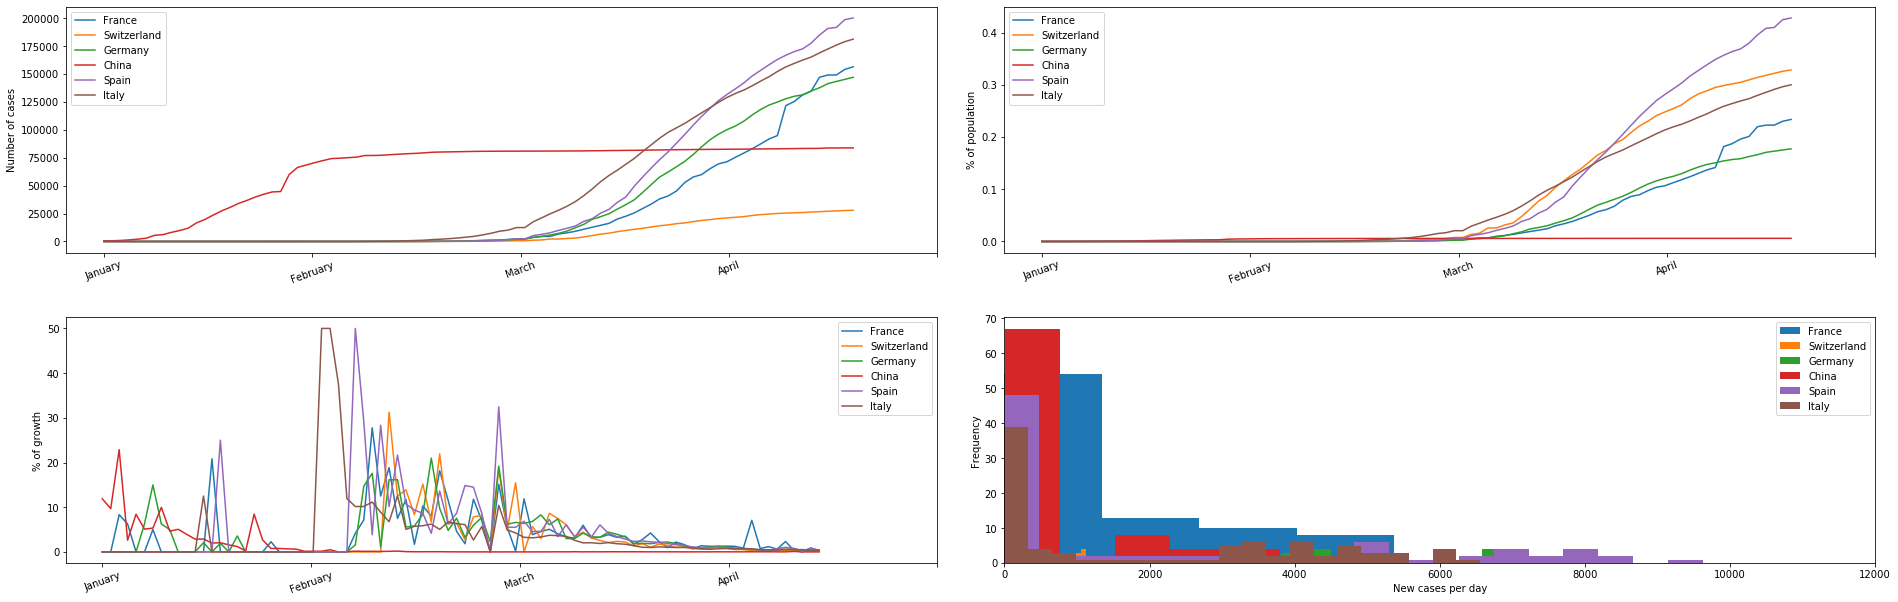

In [12]:
countries = ['France','Switzerland','Germany','China','Spain','Italy']

fig = plt.figure(figsize=(27,9))
plt.subplot(221)
for country in countries:
    toplot = country_data.loc[country,:]
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Number of cases')
plt.subplot(222)
for country in countries:
    toplot = country_data.loc[country,:]/allData.loc[country,'Pop']*100
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of population')
plt.subplot(223)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-4):
        if country_data.loc[country,country_data.columns[time]] != 0:
            for flat in range(0,4): 
                meanGrowth = 0
                Growth = (country_data.loc[country,country_data.columns[time+1+flat]]/
                      country_data.loc[country,country_data.columns[time+flat]] - 1)*100
                meanGrowth = meanGrowth + Growth
                if meanGrowth > 200:
                    meanGrowth = 200
            toplot.append(meanGrowth/4)
        else:
            toplot.append(0)
    plt.plot(toplot)
plt.legend(countries)
plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('% of growth')
plt.subplot(224)
for country in countries:
    toplot = []
    for time in range(len(country_data.columns)-1):
        toplot.append(country_data.loc[country,country_data.columns[time+1]]-
        country_data.loc[country,country_data.columns[time]])
    plt.hist(toplot,bins=20)
plt.legend(countries)
plt.xlim([0,12000])
#plt.xticks(np.linspace(0,len(allData.columns)-1,5), calendar.month_name[1:5], rotation=20)
plt.ylabel('Frequency')
plt.xlabel('New cases per day')
fig.tight_layout(pad=3.0)
plt.show()


b. all countries

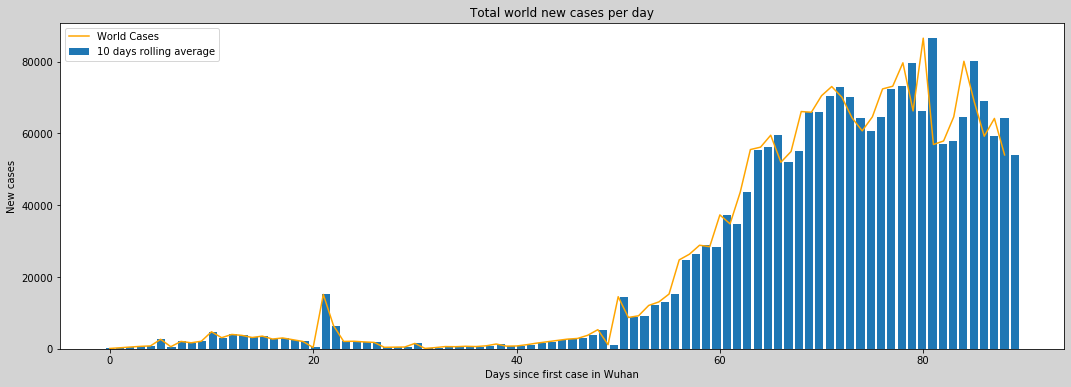

In [13]:
#Bar plot of the new cases
fig = plt.figure(figsize=[18,6])
graph = []
graph2 = []
for time in range(len(country_data.columns)-1):
    value = 0
    for country in allData.index:
        toplot = (country_data.loc[country,country_data.columns[time+1]]-country_data.loc[country,country_data.columns[time]])
        value = value  + toplot
    graph.append(value)
date = pd.date_range(start="2020-02-22",end="2020-04-16")
plt.bar(np.linspace(0,len(graph),len(graph)),np.asarray(graph))
plt.title('Total world new cases per day')
fig.set_facecolor('lightgrey')
plt.ylabel('New cases')
plt.xlabel('Days since first case in Wuhan')
plt.legend('World Cases')
for time in range(len(country_data.columns)-10):
    for country in allData.index:
        for flat in range(0,10):
            toplot = (country_data.loc[country,country_data.columns[time+1+flat]]-country_data.loc[country,country_data.columns[time+flat]])
            value = value  + toplot
        graph2.append(value/10)
plt.plot(graph,color='orange')
plt.legend(['World Cases','10 days rolling average'])
plt.show()

c. Geographical repartion

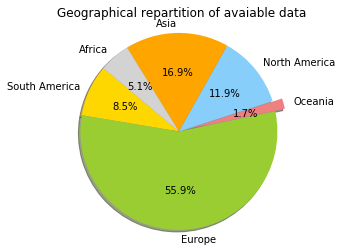

In [19]:
Continents = allData.loc[:,'Continent'].unique()
count = []
for continent in Continents:
    condObj = allData.apply(lambda x: True if x['Continent'] == continent else False, axis =1)
    count.append(len(condObj[condObj == True].index))
    

# Data to plot
labels = Continents
sizes = count
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','lightgrey']
explode = (0, 0, 0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Geographical repartition of avaiable data')
plt.axis('equal')
plt.show()

d. scatter plots

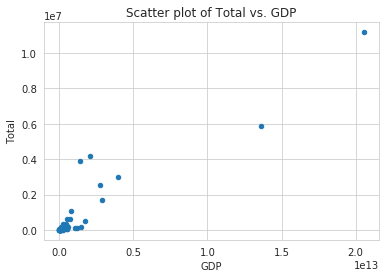

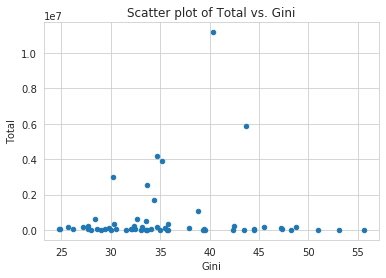

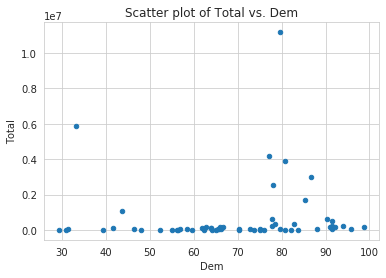

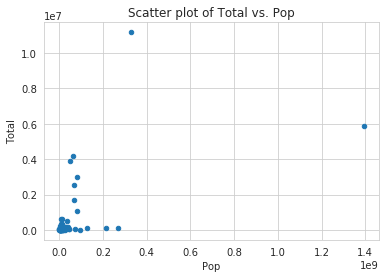

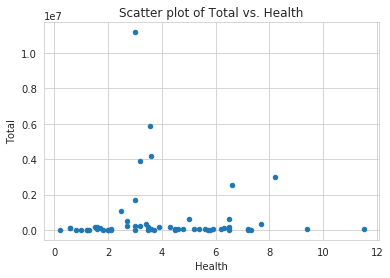

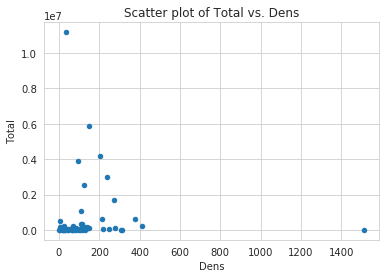

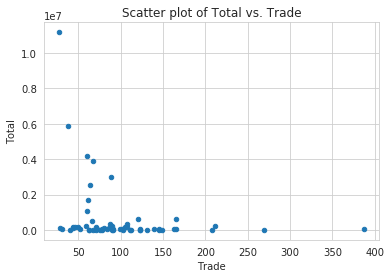

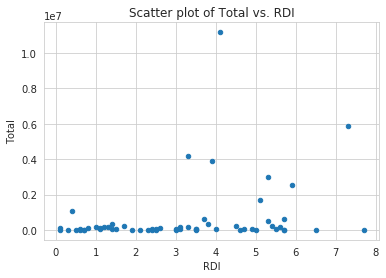

In [113]:
def plot_scatter(allData, cols, col_y = 'Total'):
    for col in cols:
        fig = plt.figure() # define plot area
        ax = fig.gca() # define axis   
        allData.plot.scatter(x = col, y = col_y, ax = ax)
        ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel(col_y)# Set text for y axis
        plt.show()    
        
num_cols=['GDP','Gini','Dem','Pop','Health','Dens','Trade','RDI']
plot_scatter(allData, num_cols)  

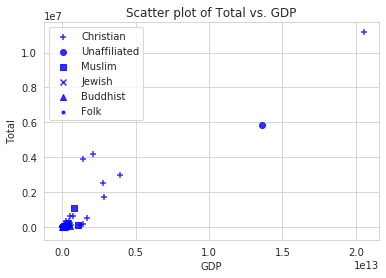

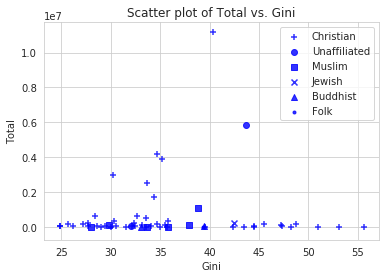

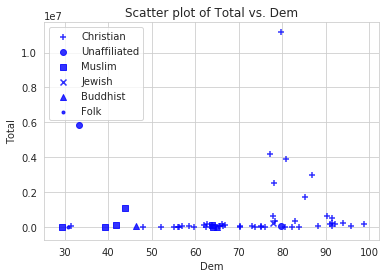

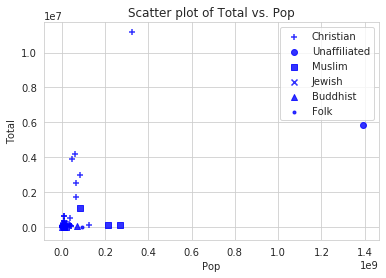

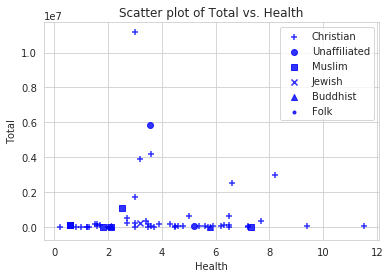

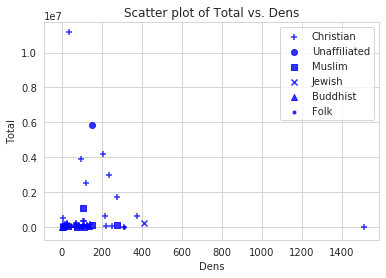

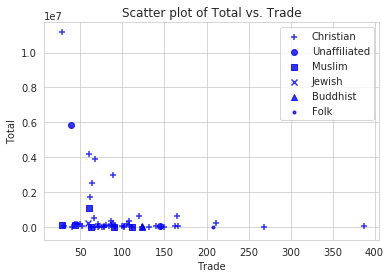

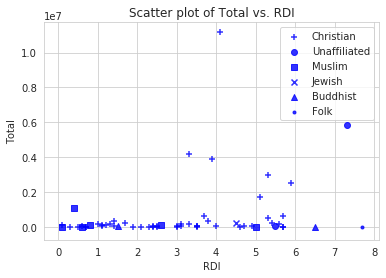

In [119]:
def plot_scatter_size(allData, cols, shape_col = 'Main Religion',
                            size_mul = 0.000025, col_y = 'Total', alpha = 0.2):
    shapes = ['+', 'o', 's', 'x', '^','.'] # pick distinctive shapes
    unique_cats = allData[shape_col].unique()
    for col in cols: # loop over the columns to plot
        sns.set_style("whitegrid")
        for i, cat in enumerate(unique_cats): # loop over the unique categories
            temp = allData[allData[shape_col] == cat]
            sns.regplot(col, col_y, data=temp, marker = shapes[i], label = cat, 
                        fit_reg = False, color = 'blue')
        plt.title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.legend()
        plt.show()

plot_scatter_size(allData, num_cols)  

### Splitting the predictors and target

In [15]:
y = allData.drop(['GDP', 'Gini', 'Dem', 'Pop', 'Health',
                  'Dens', 'Trade','Continent','RDI','Main Religion'],axis = 1)

X = allData.loc[:,['GDP', 'Gini', 'Dem', 'Pop', 'Health',
                  'Dens', 'Trade','RDI','Main Religion','Continent']]


X = X.replace(X.loc[:,'Main Religion'].unique(),[0,1,2,3,4,5])
X = X.replace(X.loc[:,'Continent'].unique(),[0,1,2,3,4,5])
X

,NY.GDP.MKTP.CD,SI.POV.GINI,Democracy index (EIU),SP.POP.TOTL,SH.MED.BEDS.ZS,EN.POP.DNST,NE.TRD.GNFS.ZS,RDI,Main Religion,Continent
Country/Region,,,,,,,,,,
Argentina,5.198715e+11,44.5,70.2,4.449450e+07,4.50,16.258510,30.700446,3.0,0,0
Armenia,1.243309e+10,30.0,47.9,2.951776e+06,3.70,103.680225,91.288962,0.3,0,1
Australia,1.433904e+12,34.7,90.9,2.498269e+07,3.90,3.249129,43.192261,5.6,0,2
Austria,4.552858e+11,30.3,82.9,8.840521e+06,7.70,107.206927,107.790262,3.8,0,1
Belarus,5.966250e+10,28.6,31.3,9.483499e+06,11.50,46.728800,139.343480,4.7,0,1
Belgium,5.427611e+11,28.4,77.8,1.143326e+07,6.50,377.214927,165.314652,5.7,0,1
Bulgaria,6.513295e+10,35.7,70.3,7.025037e+06,6.50,64.703537,131.250967,3.5,0,1
Canada,1.713342e+12,33.6,91.5,3.705776e+07,2.70,4.075308,66.223971,5.3,0,3
China,1.360815e+13,43.7,33.2,1.392730e+09,3.56,148.348833,38.246154,7.3,1,4


### Finding first cases

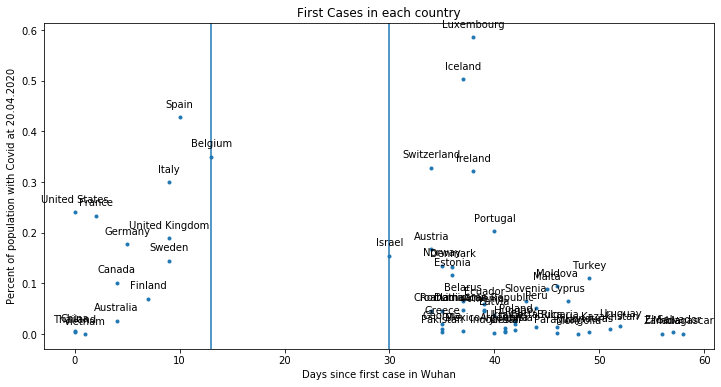

In [16]:
# Finding first case
nonZero = []
for country in y.index:
    for date in y.columns:
        if y.loc[country,date] != 0:
            index = y.columns.get_loc(date)
            nonZero.append(index)
            break
frac = y.iloc[:,-1]/X.loc[:,'Pop']*100
fig = plt.figure(figsize=[12,6])
plt.plot(nonZero,frac,'.')
plt.title('First Cases in each country')
plt.xlabel('Days since first case in Wuhan')
plt.ylabel('Percent of population with Covid at 20.04.2020')

count = 0
for x,z in zip(nonZero,frac):
    
    label = y.index[count]

    plt.annotate(label, # this is the text
                 (x,z), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    count += 1
plt.axvline(x = 13)
plt.axvline(x = 30)
plt.show()

In [17]:
# Splitting the data
RanInd = np.random.permutation(y.index)
frac = y.iloc[:,-1]/X.loc[:,'Pop']*100
y_train = frac.loc[RanInd[0:40]]
y_test = frac.loc[RanInd[41:-1]]
x_train = X.loc[RanInd[0:40],:]
x_test = X.loc[RanInd[41:-1],:]

# Import Gaussian Process 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression

# Predicting the value
LR = LinearRegression()
LR.fit(x_train,y_train)
y_predict = LR.predict(x_test)

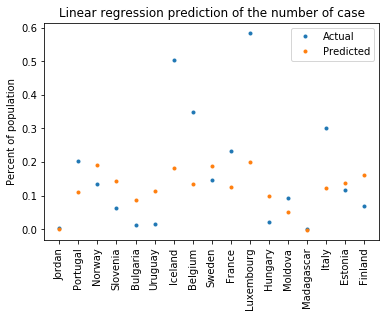

In [18]:
# Plot of linear regression prediction
plt.plot(RanInd[41:-1],y_test,'.')
plt.plot(RanInd[41:-1],y_predict,'.')
plt.legend(['Actual','Predicted'])
plt.xticks(rotation = 90)
plt.title('Linear regression prediction of the number of case')
plt.ylabel('Percent of population')
plt.show()